In [3]:
import sys
sys.path.append('/home/jxm3/research/retrieval/inversion')

In [4]:
from data_helpers import load_dpr_corpus, NQ_DEV

vd = load_dpr_corpus(NQ_DEV)
vd

/home/jxm3/.conda/envs/torch/lib/python3.9/site-packages/datasets/arrow_dataset.py:1533: FutureWarning: 'fs' was is deprecated in favor of 'storage_options' in version 2.8.0 and will be removed in 3.0.0.
You can remove this warning by passing 'storage_options=fs.storage_options' instead.
  warnings.warn(


Dataset({
    features: ['text'],
    num_rows: 849508
})

In [2]:
import transformers

mn = "distilbert-base-uncased"

m = transformers.AutoModel.from_pretrained(mn)
t = transformers.AutoTokenizer.from_pretrained(mn)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
m.to(device)
print('moved model to', device)

moved model to cuda


In [97]:
from tqdm.notebook import tqdm
import collections

batch_size = 16

msl = 64 # max sequence length

i = 0
n = 200

pbar = tqdm(total=n, leave=False)
all_hidden_states = collections.defaultdict(list)
while i < n:
    # 
    # tokenize text
    text = vd[i:i+batch_size]['text']
    tt = t(text, truncation=True, padding=True, max_length=msl, return_tensors='pt').to(device)
    # 
    # feed to model
    with torch.no_grad():
        o = m(**tt, output_hidden_states=True)
    #
    # aggregate hidden states
    # o.hidden_states is a tuple of length (n_layers).
    # each entry has shape (b, s, d).
    hs = o.hidden_states
    for j in range(len(hs)):
        all_hidden_states[j].append(hs[j].cpu())

    i += batch_size
    pbar.update(batch_size)

all_hidden_states = { k: torch.cat(v, dim=0).numpy() for k,v in all_hidden_states.items() }

print('len(all_hidden_states):', len(all_hidden_states))
print('all_hidden_states[0].shape:', all_hidden_states[0].shape)

  0%|          | 0/200 [00:00<?, ?it/s]

len(all_hidden_states): 7
all_hidden_states[0].shape: (208, 64, 768)


In [98]:
# convert [b, s, d] to [b, s, d, 32] of binary values

import struct
import numpy as np
from tqdm.notebook import trange

def binary_str(num: float) -> str:
    return ''.join('{:0>8b}'.format(c) for c in struct.pack('!f', num))

def binary(num: float) -> np.ndarray:
    # adapted from https://stackoverflow.com/a/16444778
    s = binary_str(num)
    return np.array([int(c) for c in s])

def emb_to_binary(emb: np.ndarray) -> np.ndarray:
    out_arr = np.zeros((emb.shape[0], emb.shape[1], emb.shape[2], 32))
    out_arr.shape
    for i in trange(emb.shape[0]):
        for j in range(emb.shape[1]):
            for k in range(emb.shape[2]):
                out_arr[i, j, k] = binary(emb[i, j, k].item())
    return out_arr

binary_hidden_states = { k: emb_to_binary(v) for k,v in all_hidden_states.items() }

  0%|          | 0/208 [00:00<?, ?it/s]

  0%|          | 0/208 [00:00<?, ?it/s]

  0%|          | 0/208 [00:00<?, ?it/s]

  0%|          | 0/208 [00:00<?, ?it/s]

  0%|          | 0/208 [00:00<?, ?it/s]

  0%|          | 0/208 [00:00<?, ?it/s]

  0%|          | 0/208 [00:00<?, ?it/s]

In [99]:
from math import log2

def get_bits(p: float) -> float:
    # entropy
    eps = 1e-16
    return -1 * ( p * log2(p + eps) + (1 - p) * log2(1-p + eps) )

# average over dataset to produce probability heatmap
hidden_states_heatmaps = { k: v.mean(axis=0) for k,v in binary_hidden_states.items() }

# compute bits from probabilities
hidden_states_bits = {k: np.vectorize(get_bits)(v) for k,v in hidden_states_heatmaps.items() }

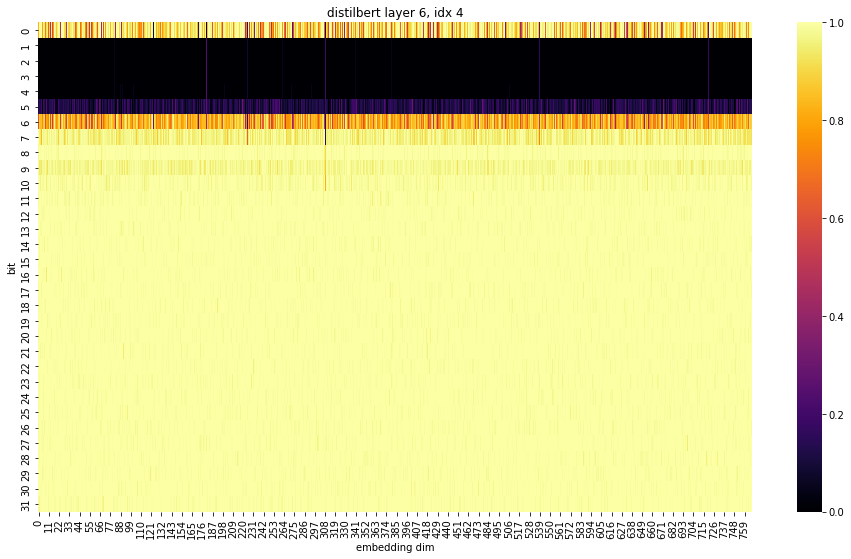

array([[ 0.82616543, -0.        , -0.        , ...,  0.99993331,
         0.99332042,  0.99037484],
       [ 0.99973321, -0.        , -0.        , ...,  0.99672959,
         0.99833204,  0.97315604],
       [ 0.99191508, -0.        , -0.        , ...,  0.99893265,
         0.99572745,  0.99459113],
       ...,
       [ 0.99759773, -0.        , -0.        , ...,  0.99833204,
         0.99459113,  0.99893265],
       [ 0.99332042, -0.        , -0.        , ...,  0.99672959,
         0.99993331,  0.99993331],
       [ 0.99037484, -0.        , -0.        , ...,  0.99893265,
         0.99973321,  0.99939968]])

In [100]:
from matplotlib import pyplot as plt
import seaborn as sns

def plot_heatmap(avg_data: np.ndarray, title: str):
    plt.figure(figsize=(16,9))    
    ax = sns.heatmap(avg_data.T, cmap='inferno')
    ax.set_title(title)
    ax.set_ylabel('bit')
    ax.set_xlabel('embedding dim')
    plt.show()
    return avg_data


layer_idx = 6
seq_idx = 4

plot_heatmap(avg_data=hidden_states_bits[layer_idx][seq_idx], title=f'Bits - distilbert layer {layer_idx}, idx {seq_idx}')

In [101]:
data = []

for layer_idx, layer_data in hidden_states_bits.items():
    print(layer_idx) # (looping by hand actually takes a few seconds..)
    for seq in range(layer_data.shape[0]):
        for emb_dim in range(layer_data.shape[1]):
            for bit in range(layer_data.shape[2]):
                bit_value = layer_data[seq, emb_dim, bit]
                data.append([layer_idx, seq, emb_dim, bit, bit_value])

0
1
2
3
4
5
6


In [102]:
import pandas as pd

df = pd.DataFrame(data, columns=['layer', 'sequence', 'embedding_dim', 'bit_idx', 'bit_value'])
df.head()

,layer,sequence,embedding_dim,bit_idx,bit_value
0,0,0,0,0,-0.0
1,0,0,0,1,-0.0
2,0,0,0,2,-0.0
3,0,0,0,3,-0.0
4,0,0,0,4,-0.0


<AxesSubplot:xlabel='layer'>

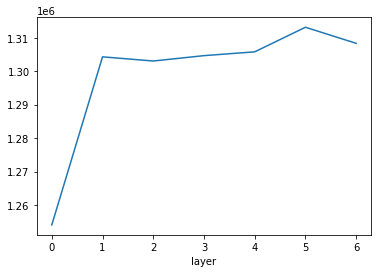

In [103]:
df.groupby('layer').sum()['bit_value'].plot()

[Text(0.5, 0, 'layer'),
 Text(0, 0.5, 'bits'),
 Text(0.5, 1.0, 'Bits per layer in DistilBERT')]

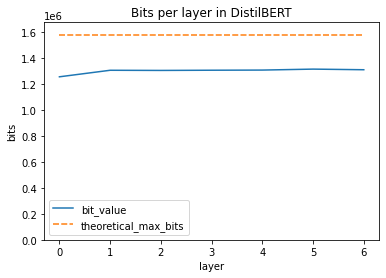

In [119]:
bert_layer = df.groupby('layer').sum()['bit_value'].to_frame()
max_bit_value = (768 * 32 * 64) # dim * bits * seq length
bert_layer['theoretical_max_bits'] = max_bit_value
ax = sns.lineplot(data=bert_layer)
ax.set(ylim=(0, max_bit_value + 100000))
ax.set(xlabel='layer', ylabel='bits', title='Bits per layer in DistilBERT')